In [1]:
from __future__ import absolute_import, division, print_function

In [49]:
import os
import json
import pandas as pd
import glob
import numpy as np
import sys
import time
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.neighbors.kde import KernelDensity
from collections import Counter
import pylab as py
import img_scale
import googlemaps
import pickle
from matplotlib import colors
import matplotlib.path as mplPath

%matplotlib inline


In [50]:
# Get CA coordinates
infile = os.path.join('..','..','data','ca_shape.csv')
ca_shape = pd.read_csv(infile)
x_coords = ca_shape['longitude'].tolist()
y_coords = ca_shape['latitude'].tolist()


In [51]:
# create path for CA outline
bbPath = mplPath.Path(np.transpose(np.array((x_coords,y_coords))),closed=True)


In [4]:
# import pre-selected and pickled dataframe
start_time = time.time()
flickr_all_clean = pd.read_pickle(os.path.join('..','..','data','flickr_all_clean.df'))
print("--- %s seconds ---" % (time.time() - start_time))


--- 24.8748879433 seconds ---


In [5]:
# Select subset of data
keyword = 'football'
start_time = time.time()
df = flickr_all_clean[flickr_all_clean['title_tags']
                                         .str.contains(keyword, na=False)]
print("--- %s seconds ---" % (time.time() - start_time))
print(df.shape)

--- 3.2036190033 seconds ---
(18104, 8)


In [170]:
# Extract long/lat and combine into 2d array
limit_lng = [-122.4,-122]
limit_lat = [37.4,37.7]
#
limit_lng = [-123.194178,-121.375941]
limit_lat = [36.911135,38.202246]
#
# limit_lat = []
#
if len(limit_lng) != 0 and len(limit_lat) != 0:
    yin = np.array((df['longitude'][(df['longitude'] > limit_lng[0]) & 
                                    (df['longitude'] < limit_lng[1]) & 
                                    (df['latitude'] > limit_lat[0]) & 
                                    (df['latitude'] < limit_lat[1])].tolist()))

    xin = np.array((df['latitude'][(df['longitude'] > limit_lng[0]) & 
                                   (df['longitude'] < limit_lng[1]) & 
                                   (df['latitude'] > limit_lat[0]) & 
                                   (df['latitude'] < limit_lat[1])].tolist()))
else:
    yin = np.array((df['longitude'][(df['longitude'] != 0.0) & (df['latitude'] != 0.0)].tolist()))
    xin = np.array((df['latitude'][(df['longitude'] != 0.0) & (df['latitude'] != 0.0)].tolist()))
XY = np.vstack([yin.ravel(), xin.ravel()]).T

In [171]:
# Run KDE
lng_max = max(yin)
lng_min = min(yin)
lat_max = max(xin)
lat_min = min(xin)
lng_max = limit_lng[0]
lng_min = limit_lng[1]
lat_max = limit_lat[0]
lat_min = limit_lat[1]
# Set up the data grid for the contour plot
xgrid = np.linspace(lng_min,lng_max,100)
ygrid = np.linspace(lat_min,lat_max,100)
X, Y = np.meshgrid(xgrid, ygrid)
#
xy = np.vstack([Y.ravel(), X.ravel()]).T
#
Xtrain = np.vstack([xin,yin]).T
Xtrain *= np.pi / 180.  # Convert lat/long to radians
#
kde = KernelDensity(bandwidth=0.0003)
kde.fit(Xtrain)
#
# Z = np.exp(kde.score_samples(xy))
# Z = Z.reshape(X.shape)

KernelDensity(algorithm='auto', atol=0, bandwidth=0.0003, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

In [172]:
patch_time = time.time()
land_mask = np.zeros(xy.shape[0], dtype=bool)
# create path for CA outline
bbPath = mplPath.Path(np.transpose(np.array((x_coords,y_coords))),closed=True)
for idx,tmp_coords in enumerate(xy):
    test = bbPath.contains_point((tmp_coords[1], tmp_coords[0]))
    land_mask[idx] = test
print("--- Masking: %s seconds ---" % (time.time() - patch_time))

print(land_mask)
#
xy *= np.pi / 180.
xy = xy[land_mask]
# evaluate only on the land: -9999 indicates ocean
Z = -9999 + np.zeros(land_mask.shape[0])
Z[land_mask] = np.exp(kde.score_samples(xy))
Z = Z.reshape(X.shape)
land_mask_reshape = land_mask.reshape(X.shape)

--- Masking: 4.52955389023 seconds ---
[ True  True  True ..., False False False]


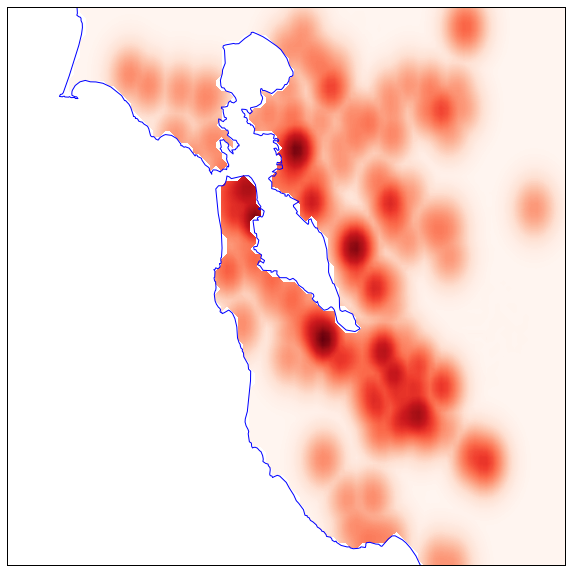

In [174]:
# Plot results
# create figure
plt.figure(figsize=(10,10))
# plot CA outline
plt.plot(x_coords,y_coords)
#  plot contours of the density
# Z_mask = Z < 0
Z_new = copy.copy(Z)
# Z_new = np.sqrt(np.sqrt(np.sqrt(Z_new/np.nanmax(Z_new))))
Z_new = np.power(Z_new/np.nanmax(Z_new),1/8)
#Z_new[Z_mask] = -9999
# levels1 = np.linspace(0, 0.99, 50)
levels = np.linspace(0,np.nanmax(Z_new), 150)
# levels = np.concatenate((levels1,levels2))
# print(levels)
# levels = np.linspace(0, np.sqrt(Z_new.max()), 150)
plt.contourf(X, Y, Z_new, levels=levels, cmap=plt.cm.Reds)
#
if len(limit_lng) != 0 and len(limit_lat) != 0:
    plt.xlim(limit_lng[0],limit_lng[1])
    plt.ylim(limit_lat[0],limit_lat[1]) 
else:
    plt.xlim(-123,-121.5)
    plt.ylim(36.7,38.5) 
#
plt.xticks([])
plt.yticks([])
outname = os.path.join('img/kde_example.png')
plt.savefig(outname,bbox_inches='tight')
plt.show()
